# Definition de fonctions annexes

In [0]:
def MAPE(y_mesuree, y_modelisee):
  # Erreur moyenne relative des modèles (MAPE)
  import numpy as np
  diff = (y_modelisee - y_mesuree)/y_mesuree
  mape = np.abs(diff).sum()/len(diff)*100
  return np.round(mape,1)

In [0]:
def plot_time_serie(data, vars_):

  import plotly.graph_objects as go

  fig = go.Figure()

  for v in vars_:
    fig.add_trace(go.Scatter(x=data[v].index, y=data[v],
                    mode='lines',
                    name=v))

  fig.show()

# Lecture des données

In [0]:
file = '/content/drive/My Drive/CasUltiWatt/AmＭioration Four.xlsx'
import pandas as pd
data = pd.read_excel(file)
data.set_index("Date",inplace=True)


# Suppression NaN et calcul d'autres variables (temps de séjour, volume de gaz consommé,...)

In [4]:
import numpy as np

print('Nombre de données avant suppression des Valeurs incohérentes: ',len(data))
data = data.dropna()


# somme des débits de gaz pour la préchauffe
data['PCH_DEBMOY_GAZ_TOT'] = data[['PCH_DEBMOY_GAZ_Z1','PCH_DEBMOY_GAZ_Z2','PCH_DEBMOY_GAZ_Z3']].sum(axis=1)

# Calcul du temps de séjours des bobines
import numpy as np
DT = data.index[1:] - data.index[:-1]
DT_minute = np.asarray(DT.seconds)/60
DT_minute = np.append([0.0],DT_minute)
data['Resid_Time'] = DT_minute # Temps de résidence des bobines dans le fours en minutes

# On supprime les valeurs abbérantes du temps de séjours (lié probablement à l'arrêt du four)
# Ici je considère que Vi est une valeure abbérantes si |Vi-moyenne(V)| > 3*ecartype(V) 

data = data[((data.Resid_Time - data.Resid_Time.mean()) / data.Resid_Time.std()).abs() < 3]
data = data[((data.PCH_DEBMOY_GAZ_TOT - data.PCH_DEBMOY_GAZ_TOT.mean()) / data.PCH_DEBMOY_GAZ_TOT.std()).abs() < 3]

# Je calcul la variable 'FOU_CONSO_GAZ_GEN': Volume de gaz consommé/bobine (en Nm3)
data['FOU_CONSO_GAZ_GEN'] = data['Resid_Time']/60*data['FOU_DEBMOY_GAZ_GEN']
# On supprime les valeurs ou 'FOU_CONSO_GAZ_GEN' est =0.0
data = data.query('FOU_CONSO_GAZ_GEN > 0.0')

# données avant les modifications
data_avt = data[data.index<='2018-08-19 06:08:10']
data['status'] = 'Avant modification'
data.loc[data.index>'2018-08-19 06:08:10', 'status'] = 'Après modification'
print('Nombre de données aprés suppression des Valeurs incohérentes: ',len(data))

Nombre de données avant suppression des Valeurs incohérentes:  21428
Nombre de données aprés suppression des Valeurs incohérentes:  21270


# Modele sur les données avant modification
Pour étudier la qualité des modèles, je regarde les points suivants:

*   Les coefficient de détermination du modèle calculé par le score, sur les données d'entraînement et les données de test. On recherche un R2 proche de 1. On vérifie que le R2 sur les données apprentissage n'est pas supérieur à celui sur les données test (indicateur de surraprentissage)
*   l'erreur moyenne relative (MAPE) sur les données test 



## Modèle sur la variable PCH_DEBMOY_GAZ_TOT

### Selection des variables explicative

In [15]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# define feature selection
fs = SelectKBest(score_func=f_regression, k=4)
# apply feature selection
X_selected = fs.fit_transform(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal



### Analyse de la corrélation sur les variables d'entrée

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


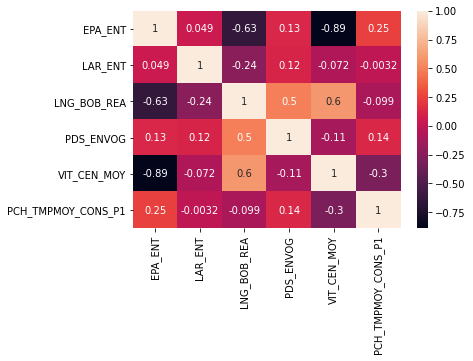

In [5]:
var_expl = ['EPA_ENT','LAR_ENT', 'LNG_BOB_REA','PDS_ENVOG','VIT_CEN_MOY','PCH_TMPMOY_CONS_P1'] # Liste des variables explicatives

pd_X = data[var_expl]
corrMatrix = pd_X.corr()

import seaborn as sn
import matplotlib.pyplot as plt
sn.heatmap(corrMatrix, annot=True)
plt.show()

Les variables d'entrées sont très corrélées, ce qui n'est pas étonnant car le poids est relié aux variables dimensionnelles via la densité de l'acier. Il faut mieux réaliser le modèle sur des variables non corrélées. On réalise une ACP pour réaliser le modèle sur les axes pincipaux

### Découpage des données en une partie entrainement du modèle et test du modèle

In [6]:
from sklearn.model_selection import train_test_split

var_selec = ['EPA_ENT','LAR_ENT', 'LNG_BOB_REA','PDS_ENVOG','VIT_CEN_MOY','PCH_TMPMOY_CONS_P1','PCH_DEBMOY_GAZ_TOT']

dataset = data_avt[var_selec].values
# Variables explicatives
X = dataset[:, :-1]
# Variable à expliquer (débit gaz préchauffage)
y = dataset[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.25)
# 
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (10662, 6) (10662,)
Test (3555, 6) (3555,)


### On adimensionne les variables puis on réalise l'ACP

In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#On adimensionne les variables d'entrée avant la PCA
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

pca = PCA()
pca.fit(X_train_scaled)

X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)



### Regression linéaire simple

In [8]:
from sklearn.linear_model import LinearRegression


linreg = LinearRegression().fit(X_train_scaled_pca, y_train)
Ypredit_test = linreg.predict(X_test_scaled_pca)

print('R2 score(training): {:.3f}'
     .format(linreg.score(X_train_scaled_pca, y_train)))
print('R2 score (test): {:.3f}'
     .format(linreg.score(X_test_scaled_pca, y_test)))
print('MAPE (%): ',MAPE(y_test,Ypredit_test))

R2 score(training): 0.669
R2 score (test): 0.674
MAPE (%):  12.0


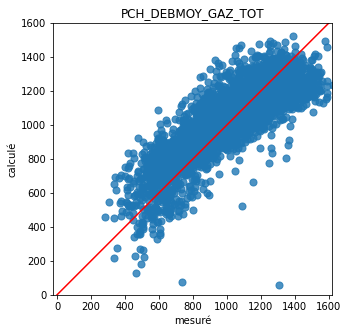

In [0]:
Ypredit_test = linreg.predict(X_test_scaled_pca)
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(y_test, Ypredit_test, marker= 'o', s=50, alpha=0.8)
plt.plot([0,1600], [0,1600], 'r-')
plt.title('PCH_DEBMOY_GAZ_TOT')
plt.xlabel('mesuré')
plt.ylabel('calculé')
plt.axis('equal')
plt.axis([0, 1600, 0, 1600])
plt.show()

### Test de la regression Lasso
Mais cela n'améliore pas le score/ regression simple

In [0]:
from sklearn.linear_model import Lasso

for alpha in [0.01,0.05,0.1,0.2,0.3,0.4,0.5, 1, 2, 3]:
    linlasso = Lasso(alpha, max_iter = 10000).fit(X_train_scaled_pca, y_train)
    r2_train = linlasso.score(X_train_scaled_pca, y_train)
    r2_test = linlasso.score(X_test_scaled_pca, y_test)
    Ypredit_test = linlasso.predict(X_test_scaled_pca)

    print('R2 score(training): {:.3f}'
     .format(r2_train))
    print('R2 score (test): {:.3f}'
     .format(r2_test))
    print('MAPE (%): ',MAPE(y_test,Ypredit_test)) 
    
   

R2 score(training): 0.669
R2 score (test): 0.675
MAPE (%):  11.9
R2 score(training): 0.669
R2 score (test): 0.675
MAPE (%):  11.9
R2 score(training): 0.668
R2 score (test): 0.675
MAPE (%):  11.9
R2 score(training): 0.668
R2 score (test): 0.674
MAPE (%):  12.0
R2 score(training): 0.668
R2 score (test): 0.674
MAPE (%):  12.0
R2 score(training): 0.667
R2 score (test): 0.673
MAPE (%):  12.0
R2 score(training): 0.666
R2 score (test): 0.672
MAPE (%):  12.0
R2 score(training): 0.657
R2 score (test): 0.663
MAPE (%):  12.2
R2 score(training): 0.630
R2 score (test): 0.638
MAPE (%):  12.9
R2 score(training): 0.606
R2 score (test): 0.614
MAPE (%):  13.6



## Modèle sur la variable volume de gaz consommé totale du four FOU_CONSO_GAZ_GEN

### Regression lineaire simple

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

var_selec = ['EPA_ENT','LAR_ENT', 'LNG_BOB_REA','PDS_ENVOG','VIT_CEN_MOY','PCH_TMPMOY_CONS_P1','FOU_CONSO_GAZ_GEN']

dataset = data_avt[var_selec].values
# Variables explicatives
X = dataset[:, :-1]
# Variable à expliquer (volume gaz général du four)
y = dataset[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.25)
# 
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

#On adimensionne les variables d'entrée avant la PCA
scaler_reglin = MinMaxScaler()

X_train_scaled = scaler_reglin.fit_transform(X_train)
X_test_scaled  = scaler_reglin.transform(X_test)
pca_reglin = PCA()
pca_reglin.fit(X_train_scaled)
X_train_scaled_pca = pca_reglin.transform(X_train_scaled)
X_test_scaled_pca = pca_reglin.transform(X_test_scaled)

linreg = LinearRegression().fit(X_train_scaled_pca, y_train)
Ypredit_test = linreg.predict(X_test_scaled_pca)

print('R2 score(training): {:.3f}'
     .format(linreg.score(X_train_scaled_pca, y_train)))
print('R2 score (test): {:.3f}'
     .format(linreg.score(X_test_scaled_pca, y_test)))
print('MAPE (%): ',MAPE(y_test,Ypredit_test))
vol_gaz_tot_mesure  = y_test.sum()
vol_gaz_tot_modelise = Ypredit_test.sum()
Delta_P = np.abs(vol_gaz_tot_mesure - vol_gaz_tot_modelise)/vol_gaz_tot_mesure*100

print('Volume Gaz mesuré sur la période: {:.1f} ; Volume Gaz mmodélisé sur la période: {:.1f} ; Delta: {:.1f} %'
     .format(vol_gaz_tot_mesure, vol_gaz_tot_modelise, Delta_P))


Train (10662, 6) (10662,)
Test (3555, 6) (3555,)
R2 score(training): 0.724
R2 score (test): 0.721
MAPE (%):  9.6
Volume Gaz mesuré sur la période: 1301465.2 ; Volume Gaz mmodélisé sur la période: 1297280.7 ; Delta: 0.3 %


In [0]:
np.where(y_test == 0.0)

(array([2072]),)

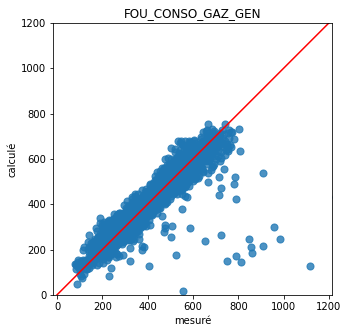

In [0]:
Ypredit_test = linreg.predict(X_test_scaled_pca)
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(y_test, Ypredit_test, marker= 'o', s=50, alpha=0.8)
plt.plot([0,1200], [0,1200], 'r-')
plt.title('FOU_CONSO_GAZ_GEN')
plt.xlabel('mesuré')
plt.ylabel('calculé')
plt.axis('equal')
plt.axis([0, 1200, 0, 1200])
plt.show()

### Regression Lasso

Train (10662, 6) (10662,)
Test (3555, 6) (3555,)
R2 score(training): 0.676
R2 score (test): 0.695
MAPE (%):  13.0


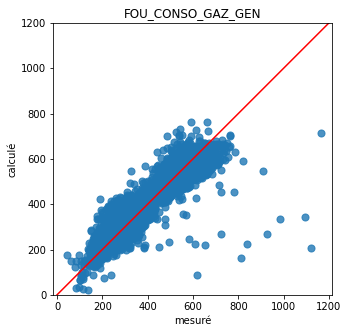

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso

var_selec = ['EPA_ENT','LAR_ENT', 'LNG_BOB_REA','PDS_ENVOG','VIT_CEN_MOY','PCH_TMPMOY_CONS_P1','FOU_CONSO_GAZ_GEN']

dataset = data_avt[var_selec].values
# Variables explicatives
X = dataset[:, :-1]
# Variable à expliquer (volume gaz général du four)
y = dataset[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.25)
# 
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

#On adimensionne les variables d'entrée avant la PCA
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)
pca = PCA()
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)



for alpha in [0.01,0.05,0.1,0.2,0.3,0.4,0.5, 1, 2, 3]:
    linlasso = Lasso(alpha, max_iter = 10000).fit(X_train_scaled_pca, y_train)
    r2_train = linlasso.score(X_train_scaled_pca, y_train)
    r2_test = linlasso.score(X_test_scaled_pca, y_test)
    Ypredit_test = linlasso.predict(X_test_scaled_pca)

     

linlasso = Lasso(0.01, max_iter = 10000).fit(X_train_scaled_pca, y_train)
print('R2 score(training): {:.3f}'.format(r2_train))
print('R2 score (test): {:.3f}'.format(r2_test))
print('MAPE (%): ',MAPE(y_test,Ypredit_test))
Ypredit_test = linreg.predict(X_test_scaled_pca)
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(y_test, Ypredit_test, marker= 'o', s=50, alpha=0.8)
plt.plot([0,1200], [0,1200], 'r-')
plt.title('FOU_CONSO_GAZ_GEN')
plt.xlabel('mesuré')
plt.ylabel('calculé')
plt.axis('equal')
plt.axis([0, 1200, 0, 1200])
plt.show()


### Regression polynomiale

(poly deg 2) R-squared score (training): 0.778
(poly deg 2) R-squared score (test): 0.634

MAPE (%):  9.0


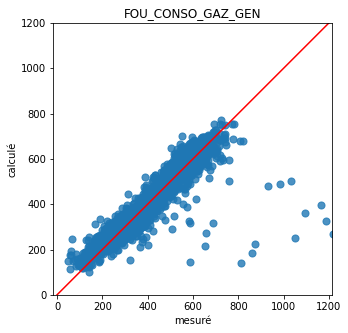

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

var_selec = ['EPA_ENT','LAR_ENT', 'LNG_BOB_REA','PDS_ENVOG','VIT_CEN_MOY','PCH_TMPMOY_CONS_P1','FOU_CONSO_GAZ_GEN']

dataset = data_avt[var_selec].values
# Variables explicatives
X = dataset[:, :-1]
# Variable à expliquer (volume gaz général du four)
y = dataset[:,-1]


scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

poly = PolynomialFeatures(degree=2)
X_F1_poly = poly.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_F1_poly, y,
                                                   random_state = 0)

poly_reg = LinearRegression().fit(X_train, y_train)

Ypredit_test = poly_reg.predict(X_test)
print('(poly deg 2) R-squared score (training): {:.3f}'
     .format(poly_reg.score(X_train, y_train)))
print('(poly deg 2) R-squared score (test): {:.3f}\n'
     .format(poly_reg.score(X_test, y_test)))
print('MAPE (%): ',MAPE(y_test,Ypredit_test))



plt.figure(figsize=(5,5))
plt.scatter(y_test, Ypredit_test, marker= 'o', s=50, alpha=0.8)
plt.plot([0,1200], [0,1200], 'r-')
plt.title('FOU_CONSO_GAZ_GEN')
plt.xlabel('mesuré')
plt.ylabel('calculé')
plt.axis('equal')
plt.axis([0, 1200, 0, 1200])
plt.show()


### Regression polynomiale + Lasso

In [0]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

var_selec = ['EPA_ENT','LAR_ENT', 'LNG_BOB_REA','PDS_ENVOG','VIT_CEN_MOY','PCH_TMPMOY_CONS_P1','FOU_CONSO_GAZ_GEN']

dataset = data_avt[var_selec].values
# Variables explicatives
X = dataset[:, :-1]
# Variable à expliquer (volume gaz général du four)
y = dataset[:,-1]


scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

poly = PolynomialFeatures(degree=2)
X_F1_poly = poly.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_F1_poly, y,
                                                   random_state = 0)


for alpha in [0.01,0.05,0.1,0.2,0.3,0.4,0.5, 1, 2, 3]:
    linlasso = Lasso(alpha, max_iter = 10000).fit(X_train, y_train)
    r2_train = linlasso.score(X_train, y_train)
    r2_test = linlasso.score(X_test, y_test)
    Ypredit_test = linlasso.predict(X_test)

    print('(poly deg 2) R-squared score (training): {:.3f}'
     .format(poly_reg.score(X_train, y_train)))
    print('(poly deg 2) R-squared score (test): {:.3f}\n'
     .format(poly_reg.score(X_test, y_test)))
    print('MAPE (%): ',MAPE(y_test,Ypredit_test))
    



(poly deg 2) R-squared score (training): 0.755
(poly deg 2) R-squared score (test): 0.689

MAPE (%):  10.5
(poly deg 2) R-squared score (training): 0.755
(poly deg 2) R-squared score (test): 0.689

MAPE (%):  10.6
(poly deg 2) R-squared score (training): 0.755
(poly deg 2) R-squared score (test): 0.689

MAPE (%):  10.8
(poly deg 2) R-squared score (training): 0.755
(poly deg 2) R-squared score (test): 0.689

MAPE (%):  11.2
(poly deg 2) R-squared score (training): 0.755
(poly deg 2) R-squared score (test): 0.689

MAPE (%):  11.3
(poly deg 2) R-squared score (training): 0.755
(poly deg 2) R-squared score (test): 0.689

MAPE (%):  11.3
(poly deg 2) R-squared score (training): 0.755
(poly deg 2) R-squared score (test): 0.689

MAPE (%):  11.3
(poly deg 2) R-squared score (training): 0.755
(poly deg 2) R-squared score (test): 0.689

MAPE (%):  11.5
(poly deg 2) R-squared score (training): 0.755
(poly deg 2) R-squared score (test): 0.689

MAPE (%):  12.2
(poly deg 2) R-squared score (trainin

### Gradient boosting decision tree

Train (10662, 6) (10662,)
Test (3555, 6) (3555,)
R2 score(training): 0.879
R2 score (test): 0.621
MAPE (%):  9.3


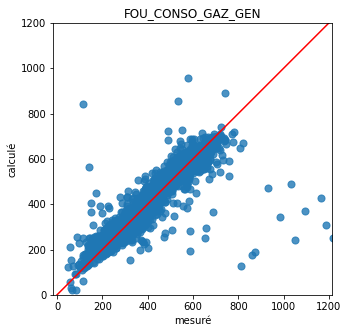

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
var_selec = ['EPA_ENT','LAR_ENT', 'LNG_BOB_REA','PDS_ENVOG','VIT_CEN_MOY','PCH_TMPMOY_CONS_P1','FOU_CONSO_GAZ_GEN']

dataset = data_avt[var_selec].values
# Variables explicatives
X = dataset[:, :-1]
# Variable à expliquer (volume gaz général du four)
y = dataset[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=0)
# 
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

#On adimensionne les variables d'entrée avant la PCA
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)
pca = PCA()
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

reg = GradientBoostingRegressor(n_estimators=200)
reg.fit(X_train, y_train)
Ypredit_test = reg.predict(X_test)
r2_train = reg.score(X_train, y_train)
r2_test  = reg.score(X_test, y_test)
  
 
print('R2 score(training): {:.3f}'.format(r2_train))
print('R2 score (test): {:.3f}'.format(r2_test))
print('MAPE (%): ',MAPE(y_test,Ypredit_test))


plt.figure(figsize=(5,5))
plt.scatter(y_test, Ypredit_test, marker= 'o', s=50, alpha=0.8)
plt.plot([0,1200], [0,1200], 'r-')
plt.title('FOU_CONSO_GAZ_GEN')
plt.xlabel('mesuré')
plt.ylabel('calculé')
plt.axis('equal')
plt.axis([0, 1200, 0, 1200])
plt.show()

# Lancement du modèle (ici la regression lin. multiple) sur la période après modification

In [12]:
var_selec = ['EPA_ENT','LAR_ENT', 'LNG_BOB_REA','PDS_ENVOG','VIT_CEN_MOY','PCH_TMPMOY_CONS_P1','FOU_CONSO_GAZ_GEN']

data_apr = data[data.index>'2018-08-19 06:08:10']

dataset = data_apr[var_selec].values
# Variables explicatives
X = dataset[:, :-1]
vol_gaz_tot_mesure = dataset[:, -1].sum()

X_scaled     = scaler_reglin.fit_transform(X)
X_scaled_pca = pca_reglin.transform(X_scaled)


Vol_gaz_Predit = linreg.predict(X_scaled_pca)
data_apr = data_apr.assign(FOU_CONSO_GAZ_GEN_MOD=Vol_gaz_Predit)
plot_time_serie(data_apr, ['FOU_CONSO_GAZ_GEN','FOU_CONSO_GAZ_GEN_MOD'])


vol_gaz_tot_modelise = Vol_gaz_Predit.sum()
Delta_P = np.abs(vol_gaz_tot_mesure - vol_gaz_tot_modelise)/vol_gaz_tot_mesure*100

print('Volume Gaz mesuré sur la période: {:.1f} ; Volume Gaz mmodélisé sur la période: {:.1f} ; Delta: {:.1f} %'
     .format(vol_gaz_tot_mesure, vol_gaz_tot_modelise, Delta_P))



Volume Gaz mesuré sur la période: 2755292.5 ; Volume Gaz mmodélisé sur la période: 2424583.5 ; Delta: 12.0 %


# Calcul d'indicateur de consommation spécifique

In [0]:
data['status'] = 'Avant modification'
data['status'].loc[data.index>='2019-09-01 00:00:00'] = 'Après modification'

# Consommation générale de gaz par poids de bobine (m3/kg)
data['FOU_CONSO_GAZ_GEN_POIDS'] = data['FOU_CONSO_GAZ_GEN']/data['PDS_ENVOG']
# Consommation de gaz (préchauffage) par poids de bobine (m3/kg)
data['PCH_CONSO_GAZ_TOT_POIDS']      = data['PCH_CONSO_GAZ_TOT']/data['PDS_ENVOG']

data_filt = data[(data['FOU_CONSO_GAZ_GEN_POIDS']>=0.1) & (data['PCH_CONSO_GAZ_TOT_POIDS']>=0.06)]


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [0]:
import plotly.express as px

fig = px.histogram(data_filt, x="FOU_CONSO_GAZ_GEN_POIDS", color="status", nbins=60)
fig.show()
fig2 = px.histogram(data_filt, x="PCH_CONSO_GAZ_TOT_POIDS", color="status", nbins=60)
fig2.show()



# Bilan énergétique

In [0]:
PCI_gaz = 10.5 #kWh/Nm3
Cp_acier = 502 #J/kg/°C
#data['Puissance_injectee_gaz'] = PCI_gaz*data['FOU_DEBMOY_GAZ_GEN']
#data['Puissance_recu_bobine']  = Cp_acier*data['Debit_bob_estime']*(data['CRE_TMPMOY_2C1']-25)/1000
data['Temps sej bobine'] =  (data['LNG_BOB_REA']/1000)/(data['VIT_CEN_MOY']) # temps de séjour en min.
data['Energie_injectee_gaz'] = PCI_gaz*data['FOU_DEBMOY_GAZ_GEN']*(data['Resid_Time']/60) # Energie gaz injectée / bobine (MWh)
data['Energie_recue_bobine'] = Cp_acier*data['PDS_ENVOG']*(data['CRE_TMPMOY_2C1']-25)*2.77778e-7



In [0]:
data[['Energie_injectee_gaz','Energie_recue_bobine']].head(10)
data['Rendement'] = data['Energie_recue_bobine']/data['Energie_injectee_gaz']


In [0]:
data[['Energie_injectee_gaz','Energie_recue_bobine']].head(10)

,Energie_injectee_gaz,Energie_recue_bobine
Date,,
2018-01-16 03:49:30,0.000000,1398.602245
2018-01-16 04:11:56,5912.026266,1402.428530
2018-01-16 04:32:42,4938.243765,1311.612083
2018-01-16 04:47:26,2773.110947,809.218021
2018-01-16 05:03:05,2950.449898,819.666211
2018-01-16 05:13:41,2359.747355,718.148523
2018-01-16 05:24:37,2827.562267,714.666868
2018-01-16 05:35:19,2929.739715,718.553597
2018-01-16 05:47:31,2536.121665,716.174501


In [0]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks")
! jupyter nbconvert --to html CasUltiWatt.ipynb

[NbConvertApp] Converting notebook CasUltiWatt.ipynb to html
[NbConvertApp] Writing 1179045 bytes to CasUltiWatt.html
